**Introduction**

---

+In this project, I will work with textual data from the USMLE Step 2 Clinical Skills exam, which is a medical licensure exam. This exam measures a trainee's ability to recognize relevant clinical facts in standardized patient encounters.

+NBME (National Board of Medical Examiners) helps health professionals across the care continuum enhance and demonstrate their knowledge—both in school and while practicing

++During this examination, each candidate sees a trained individual to represent a clinical case and documents the relevant facts of the encounter in a patient note. 

+Each patient note is scored by a trained physician who looks for the presence of certain key features relevant to the case, as described in a rubric. 

+My goal in this project is to develop an automated way to identify relevant features in each patient note, focusing on the parts of the notes related to the patient history where information from the standardized patient interview is documented.

# **Data importation**

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [2]:
!chmod 600 kaggle.json

In [3]:
!kaggle competitions download -c nbme-score-clinical-patient-notes

100% 9.83M/9.83M [00:01<00:00, 12.2MB/s]
100% 9.83M/9.83M [00:01<00:00, 6.97MB/s]


In [4]:
!unzip \*.zip && rm *.zip

Archive:  nbme-score-clinical-patient-notes.zip
  inflating: features.csv            
  inflating: patient_notes.csv       
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# **Libraries**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
# Loading some sklearn packaces for modelling.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score
# Some packages for word clouds and NER.
from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image
import spacy
# Core packages for general use throughout the notebook.
import random
import warnings
import time
import datetime

In [6]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [7]:
from ast import literal_eval
from itertools import chain
from sklearn.metrics import precision_recall_fscore_support
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import StratifiedKFold

+The next is executed with GPU

In [8]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [9]:
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.5/en_core_web_sm-2.2.5.tar.gz
import en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.5-py3-none-any.whl size=12011736 sha256=c5feee150492e6b071aa35fdae5c74a745cc41544db567c23fbcff157abe14d2
  Stored in directory: /root/.cache/pip/wheels/57/07/ed/22b6eecc1314cf0e1cbfb45ebeb5ba063dfbc86645f6f23c23
Successfully built en-core-web-sm
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 3.5.0
    Uninstalling en-core-web-sm-3.5.0:
      Successfully uninstalled en-core-web-sm-3.5.0


/usr/local/lib/python3.9/dist-packages/spacy/util.py:895: UserWarning: [W094] Model 'en_core_web_sm' (2.2.5) specifies an under-constrained spaCy version requirement: >=2.2.2. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.5.2,<3.6.0
  warnings.warn(warn_msg)


In [10]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 31.6 MB/s eta 0:00:00


In [11]:
# Loading pytorch packages.
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

In [12]:
#Setting seeds for consistent results.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [13]:
# #f1 score
!pip install tensorflow-addons
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 37.5 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [14]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.1 MB/s eta 0:00:00


In [15]:
import spacy
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import wordcloud
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import string
import random
from gensim.models import Word2Vec

In [16]:
# nlp = spacy.load('en_core_web_sm')

In [17]:
import ast

In [18]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
from sklearn import preprocessing
from sklearn.utils import class_weight as cw
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

In [20]:
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW

# **Data discovering**

+We get the dataframes

In [21]:
tr = pd.read_csv('/content/train.csv')
ts = pd.read_csv('/content/test.csv')
sub = pd.read_csv('/content/sample_submission.csv')
notes = pd.read_csv('/content/patient_notes.csv')
features = pd.read_csv('/content/features.csv')

In [22]:
print("Data dimension :: ",tr.shape)

Data dimension ::  (14300, 6)


In [23]:
tr.head(3)

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']


++Train data description : 

- id - Unique identifier for each patient note / feature pair.

- pn_num - The patient note.

- feature_num - The feature.

- case_num - The case to which this patient note belongs.

- annotation - The text(s) within a patient note indicating a feature. A feature may be indicated multiple times within a single note.

- location - Character spans indicating the location of each annotation within the note. Multiple spans may be needed to represent an annotation, in which case the spans are delimited by a semicolon ;.

In [24]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14300 entries, 0 to 14299
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           14300 non-null  object
 1   case_num     14300 non-null  int64 
 2   pn_num       14300 non-null  int64 
 3   feature_num  14300 non-null  int64 
 4   annotation   14300 non-null  object
 5   location     14300 non-null  object
dtypes: int64(3), object(3)
memory usage: 670.4+ KB


+Perfect, we have no null values in this dataframe.

In [25]:
print("Test data dimension : ",ts.shape)

Test data dimension :  (5, 4)


In [26]:
ts.head(2)

,id,case_num,pn_num,feature_num
0,00016_000,0,16,0
1,00016_001,0,16,1


In [27]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           5 non-null      object
 1   case_num     5 non-null      int64 
 2   pn_num       5 non-null      int64 
 3   feature_num  5 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 288.0+ bytes


In [28]:
sub.head(2)

,id,location
0,00016_000,0 100
1,00016_001,NaN


+A Clinical Case is the scenario (e.g., symptoms, complaints, concerns) the Standardized Patient presents to the test taker (medical student, resident or physician). 10 clinical cases are represented in this dataset.

+A Patient Note is a text detailing important information related by the patient during the encounter (physical exam and interview).

In [29]:
notes.head(2)

,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...


In [30]:
print('++ Notes example : ')
print(notes['pn_history'].iloc[0])

++ Notes example : 
17-year-old male, has come to the student health clinic complaining of heart pounding. Mr. Cleveland's mother has given verbal consent for a history, physical examination, and treatment
-began 2-3 months ago,sudden,intermittent for 2 days(lasting 3-4 min),worsening,non-allev/aggrav
-associated with dispnea on exersion and rest,stressed out about school
-reports fe feels like his heart is jumping out of his chest
-ros:denies chest pain,dyaphoresis,wt loss,chills,fever,nausea,vomiting,pedal edeam
-pmh:non,meds :aderol (from a friend),nkda
-fh:father had MI recently,mother has thyroid dz
-sh:non-smoker,mariguana 5-6 months ago,3 beers on the weekend, basketball at school
-sh:no std


In [31]:
notes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42146 entries, 0 to 42145
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   pn_num      42146 non-null  int64 
 1   case_num    42146 non-null  int64 
 2   pn_history  42146 non-null  object
dtypes: int64(2), object(1)
memory usage: 987.9+ KB


++Data description : 

- pn_num - A unique identifier for each patient note.
- case_num - A unique identifier for the clinical case a patient note represents.
- pn_history - The text of the encounter as recorded by the test taker.

+A feature is a clinically relevant concept. A rubric describes the key concepts relevant to each case.

In [32]:
features.head(2)

,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder


In [33]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   feature_num   143 non-null    int64 
 1   case_num      143 non-null    int64 
 2   feature_text  143 non-null    object
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


++Data description : 

- feature_num - A unique identifier for each feature.
- case_num - A unique identifier for each case.
- feature_text - A description of the feature.

In [34]:
print('++ Features text example : ')
print(features['feature_text'].iloc[0])

++ Features text example : 
Family-history-of-MI-OR-Family-history-of-myocardial-infarction


# **Data analysis**

* Train data

In [35]:
print("Feature column")
print("Unique values number :: ",tr['feature_num'].nunique())
print("Minimum value :: ",tr['feature_num'].min())
print("Maximum value :: ",tr['feature_num'].max())

Feature column
Unique values number ::  143
Minimum value ::  0
Maximum value ::  916


In [36]:
print("pn column")
print("Unique values number :: ",tr['pn_num'].nunique())
print("Minimum value :: ",tr['pn_num'].min())
print("Maximum value :: ",tr['pn_num'].max())

pn column
Unique values number ::  1000
Minimum value ::  16
Maximum value ::  95333


In [37]:
print("case_num column")
print("Unique values number :: ",tr['case_num'].nunique())
print("Minimum value :: ",tr['case_num'].min())
print("Maximum value :: ",tr['case_num'].max())

case_num column
Unique values number ::  10
Minimum value ::  0
Maximum value ::  9


<Axes: xlabel='case_num', ylabel='count'>

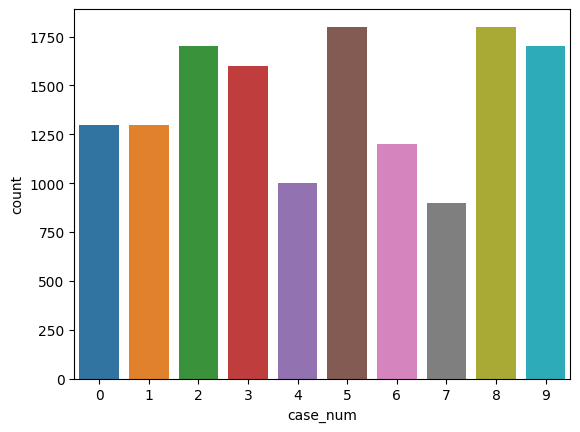

In [38]:
sns.countplot(data=tr,x='case_num')

+We will plot the distribution of clinical cases : 

In [39]:
import plotly.express as px
notes_counts = notes.groupby("case_num").count()
fig = px.bar(data_frame =notes_counts, 
             x = notes_counts.index,
             y = 'pn_num' , 
             color = "pn_num",
             color_continuous_scale="Emrld") 
fig.update_layout(title = {
        'text': 'Distribution of patient notes for each case',
        'y':0.95,
        'x':0.48,
        'xanchor': 'center',
        'yanchor': 'top'} ,
                   xaxis = dict(
        tickmode = 'array',
        tickvals = [0, 1,2, 3, 4,5, 6,7,8,9],
        ticktext = ['Case 0', 'Case 1', 'Case 2', 'Case 3', 'Case 4', 'Case 5', 'Case 6', 'Case 7', 'Case 8', 'Case 9']),
                  template = "plotly_white")
fig.show()

* Distribution of pn_num

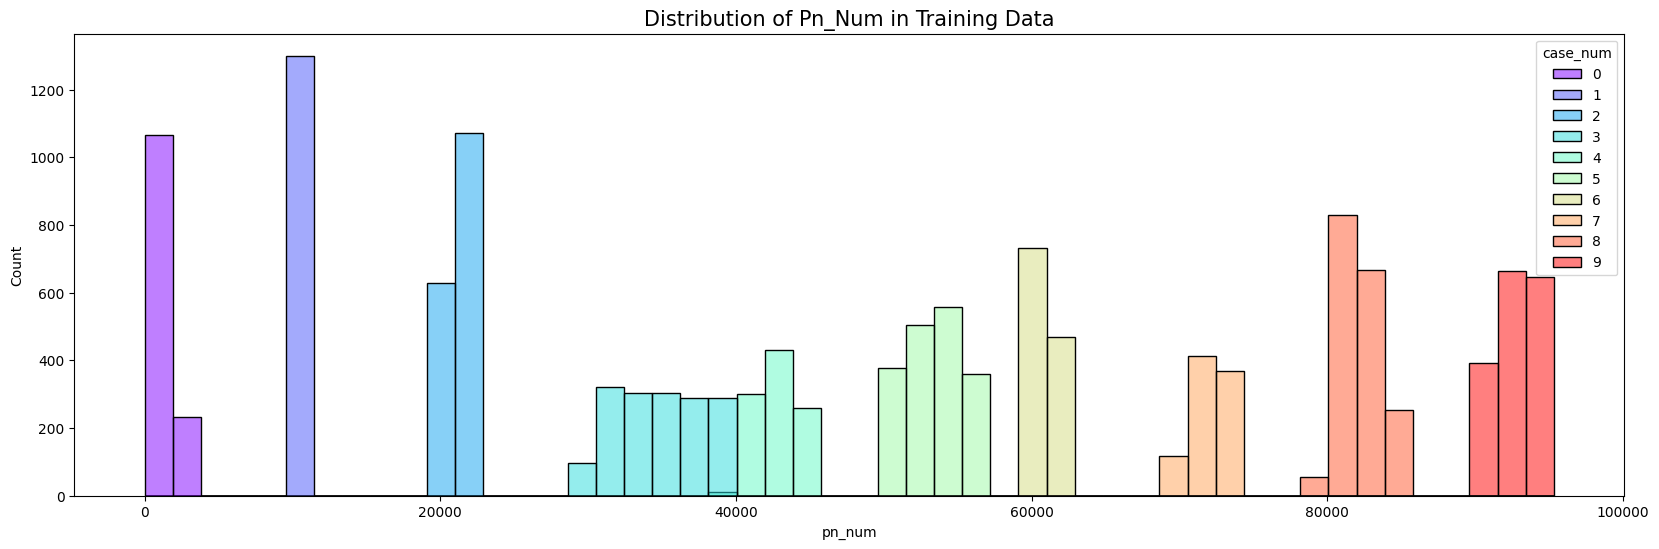

In [40]:
plt.figure(figsize=(20, 6))
sns.histplot(x='pn_num', data=tr, hue='case_num', bins=50, palette='rainbow')
plt.title('Distribution of Pn_Num in Training Data', fontsize=15)
plt.show()

* Features data

In [41]:
features['feature_text_length'] = features['feature_text'].apply(len)

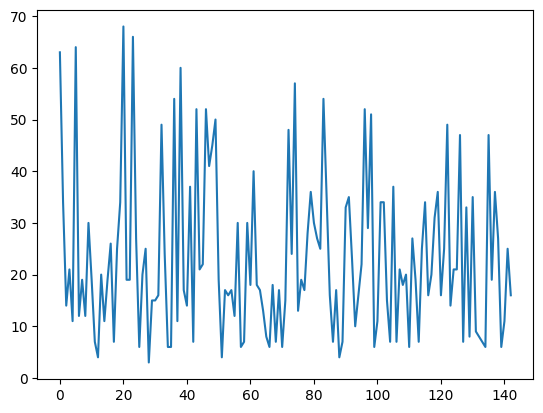

In [42]:
plt.plot(features['feature_text_length'])

In [43]:
print("Minimum length :: ",features['feature_text_length'].min())
print("Maximum length :: ",features['feature_text_length'].max())
print("Mean length :: ",int(features['feature_text_length'].mean()))

Minimum length ::  3
Maximum length ::  68
Mean length ::  23


* Notes

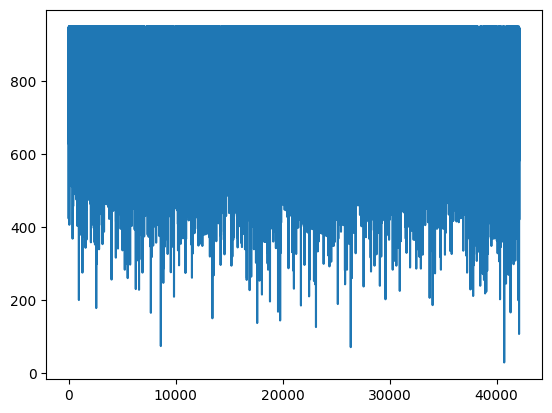

In [44]:
notes['pn_text_length'] = notes['pn_history'].apply(len)
plt.plot(notes['pn_text_length'])

In [45]:
print("Minimum length :: ",notes['pn_text_length'].min())
print("Maximum length :: ",notes['pn_text_length'].max())
print("Mean length :: ",int(notes['pn_text_length'].mean()))

Minimum length ::  30
Maximum length ::  950
Mean length ::  818


# **Useful functions**

In [46]:
#Word cloud
def WC_fct(sents):
  wordcloud = WordCloud(collocations = False,width=1600, height=800,background_color='white',
              #stopwords=stopwords,
                          max_words=100,
                          #max_font_size=40, 
                          random_state=42
                         ).generate(" ".join(sents)) # needs to be strings and function computes frequencies
  print(wordcloud)
  plt.figure(figsize=(9,8))
  fig = plt.figure(1)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

In [49]:
def clean_words(x): #x is a list of words
  """
  -remove numbers,times,etc...
  -remove addresses
  -remove persons, companies,agencies,...
  """
  res=[]
  for w in x:
    if ((w.isalpha())&(w != 'not')):
      res.append(w)
  #if a person name or organization name is detected, we will remove it
  doc = nlp(' '.join(res))
  for wl in doc.ents:
    if wl.label_ in ['PERSON','ORG']:
      words = wl.text.split() #because the spacy model can make consecutive words in one label
      for ww in words:
        if ww in res:
          res.remove(ww)
  #
  return res

In [50]:
def text_preprocessing(s):
    ps = PorterStemmer()
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    #remove all URLs
    s = re.sub(r"\S*https?:\S*", " ", s)
    # Isolate and remove punctuations 
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,?])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # remove enron name from meeting emails data
    s = re.sub(r'enron', '', s)
    # Remove stopwords except 'can'
    s = " ".join([ps.stem(word) for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['can']])
    '''
    #remove numbers, times, addresses, person name, companies names, agencies, etc...
    ss = s.split()
    res=[]
    for w in ss:
      if (w.isalpha()):
        res.append(w)

    doc = nlp(' '.join(res))
    for wl in doc.ents:
      if wl.label_ in ['PERSON','ORG']:
        words = wl.text.split() #because the spacy model can make consecutive words in one label
        for ww in words:
          if ww in res:
            res.remove(ww)
    s=' '.join(res)
    '''
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()   
    return s

In [51]:
def clean_data2(x):
  #remove numbers, times, addresses, person name, companies names, agencies, etc...
  ss = s.split()
  res=[]
  for w in ss:
    if (w.isalpha()):
      res.append(w)

  doc = nlp(' '.join(res))
  for wl in doc.ents:
    if wl.label_ in ['PERSON','ORG']:
      words = wl.text.split() #because the spacy model can make consecutive words in one label
      for ww in words:
        if ww in res:
          res.remove(ww)
  s=' '.join(res)
  
  return s

In [52]:
import datetime
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today() 

In [53]:
def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']
    plt.figure(figsize=(20, 5))
    y1 = history.history['categorical_accuracy']
    y2 = history.history['val_categorical_accuracy']
    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]
    plt.subplot(121)
    plt.plot(y1)
    plt.plot(y2)
    plt.title('Model Accuracy\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    y1 = history.history['loss']
    y2 = history.history['val_loss']
    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]
    plt.subplot(122)
    plt.plot(y1)
    plt.plot(y2)
    plt.title('Model Loss\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")
    plt.show()

In [54]:
def micro_f1(preds, truths):
    """
    Micro f1 on binary arrays.

    Args:
        preds (list of lists of ints): Predictions.
        truths (list of lists of ints): Ground truths.

    Returns:
        float: f1 score.
    """
    # Micro : aggregating over all instances
    preds = np.concatenate(preds)
    truths = np.concatenate(truths)
    return f1_score(truths, preds)

In [55]:
def spans_to_binary(spans, length=None):
    """
    Converts spans to a binary array indicating whether each character is in the span.

    Args:
        spans (list of lists of two ints): Spans.

    Returns:
        np array [length]: Binarized spans.
    """
    length = np.max(spans) if length is None else length
    binary = np.zeros(length)
    for start, end in spans:
        binary[start:end] = 1
    return binary


def span_micro_f1(preds, truths):
    """
    Micro f1 on spans.

    Args:
        preds (list of lists of two ints): Prediction spans.
        truths (list of lists of two ints): Ground truth spans.

    Returns:
        float: f1 score.
    """
    bin_preds = []
    bin_truths = []
    for pred, truth in zip(preds, truths):
        if not len(pred) and not len(truth):
            continue
        length = max(np.max(pred) if len(pred) else 0, np.max(truth) if len(truth) else 0)
        bin_preds.append(spans_to_binary(pred, length))
        bin_truths.append(spans_to_binary(truth, length))
    return micro_f1(bin_preds, bin_truths)

In [56]:
def create_labels_for_scoring(df):
    # example: ['0 1', '3 4'] -> ['0 1; 3 4']
    df['location_for_create_labels'] = [ast.literal_eval(f'[]')] * len(df)
    for i in range(len(df)):
        lst = df.loc[i, 'location']
        if lst:
            new_lst = ';'.join(lst)
            df.loc[i, 'location_for_create_labels'] = ast.literal_eval(f'[["{new_lst}"]]')
    # create labels
    truths = []
    for location_list in df['location_for_create_labels'].values:
        truth = []
        if len(location_list) > 0:
            location = location_list[0]
            for loc in [s.split() for s in location.split(';')]:
                start, end = int(loc[0]), int(loc[1])
                truth.append([start, end])
        truths.append(truth)
    return truths


def get_char_probs(texts, predictions, tokenizer):
    results = [np.zeros(len(t)) for t in texts]
    for i, (text, prediction) in enumerate(zip(texts, predictions)):
        encoded = tokenizer(text, 
                            add_special_tokens=True,
                            return_offsets_mapping=True)
        for idx, (offset_mapping, pred) in enumerate(zip(encoded['offset_mapping'], prediction)):
            start = offset_mapping[0]
            end = offset_mapping[1]
            results[i][start:end] = pred
    return results


def get_results(char_probs, th=0.5):
    results = []
    for char_prob in char_probs:
        result = np.where(char_prob >= th)[0] + 1
        result = [list(g) for _, g in itertools.groupby(result, key=lambda n, c=itertools.count(): n - next(c))]
        result = [f"{min(r)} {max(r)}" for r in result]
        result = ";".join(result)
        results.append(result)
    return results


def get_predictions(results):
    predictions = []
    for result in results:
        prediction = []
        if result != "":
            for loc in [s.split() for s in result.split(';')]:
                start, end = int(loc[0]), int(loc[1])
                prediction.append([start, end])
        predictions.append(prediction)
    return predictions

# **Main**

In [57]:
tr.head(2)

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']


In [58]:
tr['annotation1'] = tr['annotation'].apply(ast.literal_eval)
tr['location1'] = tr['location'].apply(ast.literal_eval)

In [59]:
tr.head(2)

,id,case_num,pn_num,feature_num,annotation,location,annotation1,location1
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],[dad with recent heart attcak],[696 724]
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],"[mom with ""thyroid disease]",[668 693]


* Merge dataframes

+Merge train data

In [60]:
tr = tr.merge(features, on=['feature_num', 'case_num'], how='left')
tr = tr.merge(notes, on=['pn_num', 'case_num'], how='left')
tr.head(2)

,id,case_num,pn_num,feature_num,annotation,location,annotation1,location1,feature_text,feature_text_length,pn_history,pn_text_length
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],[dad with recent heart attcak],[696 724],Family-history-of-MI-OR-Family-history-of-myoc...,63,HPI: 17yo M presents with palpitations. Patien...,938
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],"[mom with ""thyroid disease]",[668 693],Family-history-of-thyroid-disorder,34,HPI: 17yo M presents with palpitations. Patien...,938


+Merge test data

In [61]:
ts = ts.merge(features, on=['feature_num', 'case_num'], how='left')
ts = ts.merge(notes, on=['pn_num', 'case_num'], how='left')
ts.head(2)

,id,case_num,pn_num,feature_num,feature_text,feature_text_length,pn_history,pn_text_length
0,00016_000,0,16,0,Family-history-of-MI-OR-Family-history-of-myoc...,63,HPI: 17yo M presents with palpitations. Patien...,938
1,00016_001,0,16,1,Family-history-of-thyroid-disorder,34,HPI: 17yo M presents with palpitations. Patien...,938


In [62]:
tr['annotation_length'] = tr['annotation1'].apply(len)

<Axes: xlabel='annotation_length', ylabel='count'>

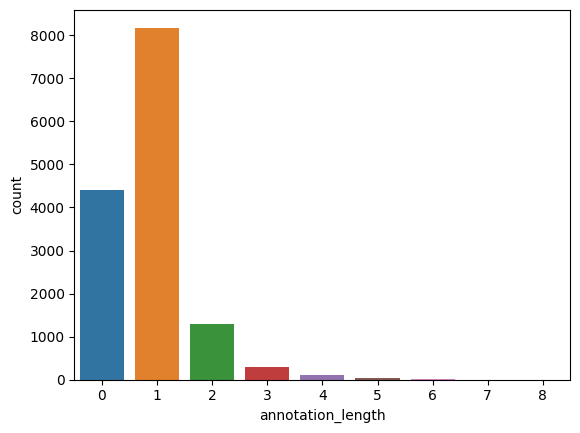

In [63]:
sns.countplot(data=tr,x='annotation_length')

In [64]:
print("Number of Empty annotions and locations = ", len(tr[tr["annotation_length"]==0]))
print("Percentage of Empty annotions and locations = ", round(len(tr[tr["annotation_length"]==0]) / len(tr),2)*100,"%")

Number of Empty annotions and locations =  4399
Percentage of Empty annotions and locations =  31.0 %


+31% of the notes are empty, i.e. these patients do not have an identified case.

* Features text 

+The words most present in the texts of the features.

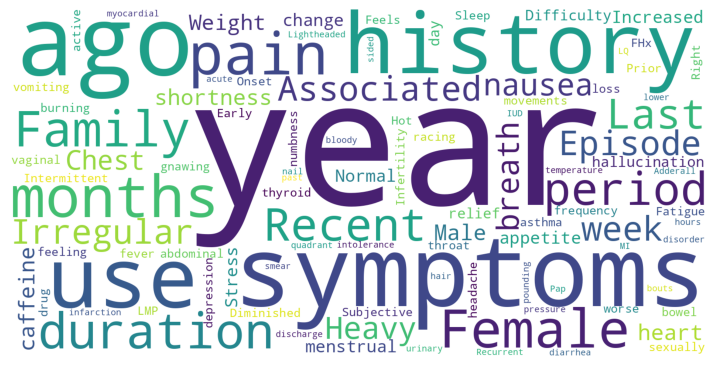

In [65]:
WC_fct(features['feature_text'].values)

In [66]:
top = Counter(list(features['feature_text'].values))
print("Top most frequent 20 words : ",top.most_common(20))

Top most frequent 20 words :  [('Female', 7), ('Male', 3), ('17-year', 2), ('20-year', 2), ('Nausea', 2), ('35-year', 2), ('Family-history-of-MI-OR-Family-history-of-myocardial-infarction', 1), ('Family-history-of-thyroid-disorder', 1), ('Chest-pressure', 1), ('Intermittent-symptoms', 1), ('Lightheaded', 1), ('No-hair-changes-OR-no-nail-changes-OR-no-temperature-intolerance', 1), ('Adderall-use', 1), ('Shortness-of-breath', 1), ('Caffeine-use', 1), ('heart-pounding-OR-heart-racing', 1), ('Few-months-duration', 1), ('No-vaginal-discharge', 1), ('Weight-loss', 1), ('Not-sexually-active', 1)]


* pn_history

+The words most present in the texts of the notes.

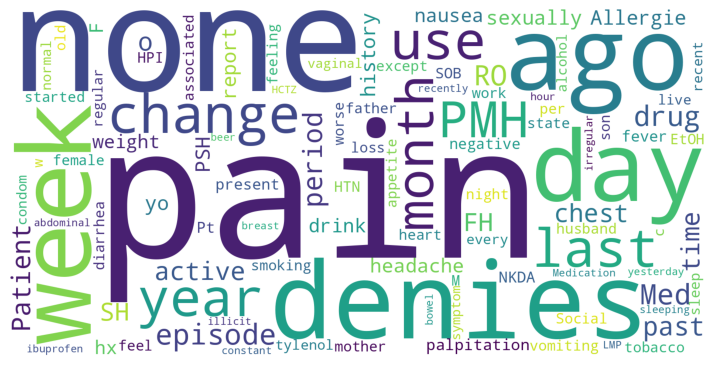

In [67]:
WC_fct(tr['pn_history'].values)

* Annotations

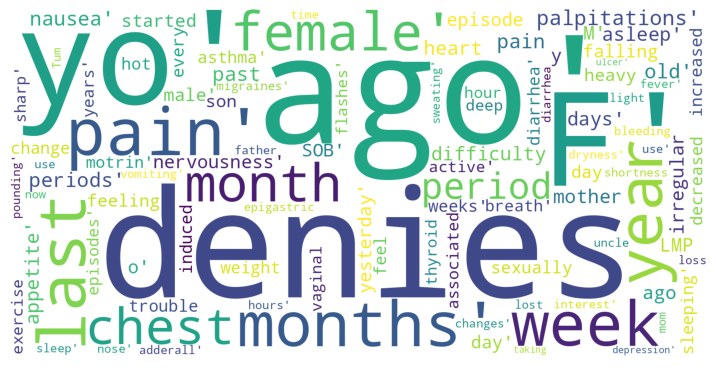

In [68]:
all_annotations = []
for ann in tr['annotation'].values:
  all_annotations.append("".join(ann))
WC_fct(all_annotations)

In [69]:
tr.head(2)

,id,case_num,pn_num,feature_num,annotation,location,annotation1,location1,feature_text,feature_text_length,pn_history,pn_text_length,annotation_length
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],[dad with recent heart attcak],[696 724],Family-history-of-MI-OR-Family-history-of-myoc...,63,HPI: 17yo M presents with palpitations. Patien...,938,1
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],"[mom with ""thyroid disease]",[668 693],Family-history-of-thyroid-disorder,34,HPI: 17yo M presents with palpitations. Patien...,938,1


* Annotations visualization

---

+Exp 1 :

+Show an example of notes and features identified in this document.

In [70]:
pn_num_exp1 = 224

In [71]:
from spacy import displacy
nlp = spacy.blank('en')
loc = list(tr.loc[(tr.pn_num==pn_num_exp1) & (tr.location!='[]'), 'location'].str.replace("['", "", regex=False).str.replace("']", "", regex=False))
text = notes[notes.pn_num==pn_num_exp1].pn_history.values[0]
doc = nlp.make_doc(text)
ents = []
for l in loc:
    start, end = l.split(' ')
    ent = doc.char_span(int(start), int(end), label='annotation')
    ents.append(ent)
doc.ents = ents
color = {"Annotation": '#A32EFF'}
displacy.render(doc, style="ent", jupyter=True, options={'colors': color})

* Abbreviations used

+Show abbreviations in the patient notes

In [72]:
pl = notes['pn_history'].tolist()
pl1 = [i.split('\n', 1)[0] for i in pl]

pattern = re.compile('(.*?)\:') #regular pattern to identify Abbreviations

vals = []
for item in range(len(pl1)):
    val = pattern.findall(pl1[item])
    if val:
        if(len(val[0]) < 10):
            vals.append(val[0])
print(set(vals))

{'ID', '35yo M CC', 'hpi ', 'Hx', 'PC', 'C/C', '-CC', 'CC/ID', 'HPI/CC', 'HIi', 'c/c', 'HX', '-HPI', 'Name', 'HIPI', 'HI', 'CC', 'PMI', 'Data', 'HxPC', 'CO', 'PMH', 'source', 'PMHx', 'VS', 'PT', 'HPIl', 'c/o', 'HPIN ', 'HP', 'pmh', 'PCx', 'HPI', 'ID / CC', 'History', 'HPi', 'HIP', 'ID/CC', 'CC ', '26f CC', 'cc/HPI', 'Pt', 'co', 'cc ', 'C.C.', 'Patient', 'HOPI', 'Name/Age', 'C.C', 'Hpi', 'hpi', 'cc', 'Px', 'IDCC', 'HPT', 'ID/HPI', '- HPI', 'Complaint', 'PI', 'Gen', 'HIstory', 'headache', 'C', 'HPI ', 'HISTORY ', 'HOI', 'HDI', 'hopi', 'HPIx', 'HPC', 'C/c', 'Cc', 'ID+CC', '- HPI ', 'HOPC', 'C/O', 'ccc', 'HxPI', '35yof cc', 'GA', 'Identity', '45yo F CC', 'CC/HPI', 'HpI', 'complaint', 'PHI', 'Profile', 'HPHI'}


* Group data by case_num

In [73]:
train_case_num_group = tr.groupby(tr['case_num'])
train_feature_num_group = tr.groupby(tr['feature_num'])
for case_num, each_case in train_case_num_group:    
    print('case_num:', case_num)
    display(each_case.head(3))

case_num: 0


,id,case_num,pn_num,feature_num,annotation,location,annotation1,location1,feature_text,feature_text_length,pn_history,pn_text_length,annotation_length
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],[dad with recent heart attcak],[696 724],Family-history-of-MI-OR-Family-history-of-myoc...,63,HPI: 17yo M presents with palpitations. Patien...,938,1
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],"[mom with ""thyroid disease]",[668 693],Family-history-of-thyroid-disorder,34,HPI: 17yo M presents with palpitations. Patien...,938,1
2,00016_002,0,16,2,['chest pressure'],['203 217'],[chest pressure],[203 217],Chest-pressure,14,HPI: 17yo M presents with palpitations. Patien...,938,1


case_num: 1


,id,case_num,pn_num,feature_num,annotation,location,annotation1,location1,feature_text,feature_text_length,pn_history,pn_text_length,annotation_length
1300,10004_100,1,10004,100,['no discharge'],['206 218'],[no discharge],[206 218],No-vaginal-discharge,20,20 y/o F c/o abdominal pain \r\n5/10. from la...,600,1
1301,10004_101,1,10004,101,[],[],[],[],Weight-loss,11,20 y/o F c/o abdominal pain \r\n5/10. from la...,600,0
1302,10004_102,1,10004,102,['last sexual encounter 9 months ago'],['529 563'],[last sexual encounter 9 months ago],[529 563],Not-sexually-active,19,20 y/o F c/o abdominal pain \r\n5/10. from la...,600,1


case_num: 2


,id,case_num,pn_num,feature_num,annotation,location,annotation1,location1,feature_text,feature_text_length,pn_history,pn_text_length,annotation_length
2600,20001_200,2,20001,200,[],[],[],[],Prior-normal-periods,20,CC: 44 yo female c/o irregular periods\r\nHPI:...,811,0
2601,20001_201,2,20001,201,[],[],[],[],Last-Pap-smear-I-year-ago,25,CC: 44 yo female c/o irregular periods\r\nHPI:...,811,0
2602,20001_202,2,20001,202,[],[],[],[],IUD,3,CC: 44 yo female c/o irregular periods\r\nHPI:...,811,0


case_num: 3


,id,case_num,pn_num,feature_num,annotation,location,annotation1,location1,feature_text,feature_text_length,pn_history,pn_text_length,annotation_length
4300,30037_300,3,30037,300,['Uncle with bleeding ulcer'],['844 869'],[Uncle with bleeding ulcer],[844 869],FHx-of-PUD-OR-Family-history-of-peptic-ulcer-d...,52,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,933,1
4301,30037_301,3,30037,301,['pain is located in the epigastric region'],['124 164'],[pain is located in the epigastric region],[124 164],Epigastric-discomfort,21,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,933,1
4302,30037_302,3,30037,302,['stools have appeared darker'],['508 535'],[stools have appeared darker],[508 535],Darker-bowel-movements,22,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,933,1


case_num: 4


,id,case_num,pn_num,feature_num,annotation,location,annotation1,location1,feature_text,feature_text_length,pn_history,pn_text_length,annotation_length
5900,40045_400,4,40045,400,"['denies palpitations', 'denies tremors', 'den...","['468 474;491 503', '468 474;546 553', '468 47...","[denies palpitations, denies tremors, denies s...","[468 474;491 503, 468 474;546 553, 468 474;505...",Lack-of-other-thyroid-symptoms,30,Mrs. Moore is a 45 year old female presenting ...,755,3
5901,40045_401,4,40045,401,"['nervousness', 'nervousness', 'nervousness']","['52 63', '82 93', '206 217']","[nervousness, nervousness, nervousness]","[52 63, 82 93, 206 217]",anxious-OR-nervous,18,Mrs. Moore is a 45 year old female presenting ...,755,3
5902,40045_402,4,40045,402,[],[],[],[],Stress-due-to-caring-for-elderly-parents,40,Mrs. Moore is a 45 year old female presenting ...,755,0


case_num: 5


,id,case_num,pn_num,feature_num,annotation,location,annotation1,location1,feature_text,feature_text_length,pn_history,pn_text_length,annotation_length
6900,50072_500,5,50072,500,[],[],[],[],Onset-5-years-ago,17,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,753,0
6901,50072_501,5,50072,501,['F'],['22 23'],[F],[22 23],Female,6,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,753,1
6902,50072_502,5,50072,502,[],[],[],[],No-caffeine-use,15,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,753,0


case_num: 6


,id,case_num,pn_num,feature_num,annotation,location,annotation1,location1,feature_text,feature_text_length,pn_history,pn_text_length,annotation_length
8700,60004_600,6,60004,600,['feeling febrile'],['293 308'],[feeling febrile],[293 308],Subjective-fevers,17,17 y/o male with ches pain. Pt woke up yesterd...,791,1
8701,60004_601,6,60004,601,['male'],['7 11'],[male],[7 11],Male,4,17 y/o male with ches pain. Pt woke up yesterd...,791,1
8702,60004_602,6,60004,602,['17 y/o'],['0 6'],[17 y/o],[0 6],17-year,7,17 y/o male with ches pain. Pt woke up yesterd...,791,1


case_num: 7


,id,case_num,pn_num,feature_num,annotation,location,annotation1,location1,feature_text,feature_text_length,pn_history,pn_text_length,annotation_length
9900,70087_700,7,70087,700,['F'],['11 12'],[F],[11 12],Female,6,HPI: 35 yo F c/o mens cycles dysregularities\r...,428,1
9901,70087_701,7,70087,701,[],[],[],[],Weight-Gain,11,HPI: 35 yo F c/o mens cycles dysregularities\r...,428,0
9902,70087_702,7,70087,702,['menorrhagea'],['82 93'],[menorrhagea],[82 93],heavy-periods-OR-irregular-periods,34,HPI: 35 yo F c/o mens cycles dysregularities\r...,428,1


case_num: 8


,id,case_num,pn_num,feature_num,annotation,location,annotation1,location1,feature_text,feature_text_length,pn_history,pn_text_length,annotation_length
10800,80039_800,8,80039,800,"['appetite has increased', 'eating more']","['468 490', '502 513']","[appetite has increased, eating more]","[468 490, 502 513]",Increased-appetite,18,Loraine Wicks is a 67 y.o. woman here for diff...,921,2
10801,80039_801,8,80039,801,['son past away at the end of June'],['171 203'],[son past away at the end of June],[171 203],Son-died-3-weeks-ago,20,Loraine Wicks is a 67 y.o. woman here for diff...,921,1
10802,80039_802,8,80039,802,['woman'],['27 32'],[woman],[27 32],Female,6,Loraine Wicks is a 67 y.o. woman here for diff...,921,1


case_num: 9


,id,case_num,pn_num,feature_num,annotation,location,annotation1,location1,feature_text,feature_text_length,pn_history,pn_text_length,annotation_length
12600,90127_900,9,90127,900,"['tylenol no relief', 'ibuprofen no relief']","['251 258;284 293', '264 273;284 293']","[tylenol no relief, ibuprofen no relief]","[251 258;284 293, 264 273;284 293]",No-relief-with-Motrin-OR-no-relief-with-tylenol,47,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,749,2
12601,90127_901,9,90127,901,['20 year old'],['34 45'],[20 year old],[34 45],20-year,7,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,749,1
12602,90127_902,9,90127,902,['yesterday'],['102 111'],[yesterday],[102 111],1-day-duration-OR-2-days-duration,33,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,749,1


# **Modelling**

---



# **Bert Model**

+Our goal is to predict the indices of the feature text : pair of (start_index, end_text) that identify the location of feature.

* Prepare data

+Clean text functions

In [ ]:
def process_feature_text(text):
    text = re.sub('I-year', '1-year', text)
    text = re.sub('-OR-', " or ", text)
    text = re.sub('-', ' ', text)
    return text
def clean_spaces(txt):
    txt = re.sub('\n', ' ', txt)
    txt = re.sub('\t', ' ', txt)
    txt = re.sub('\r', ' ', txt)
    return txt

+Data preparation functions

In [ ]:
def load_and_prepare_test(df):
    df['pn_history'] = df['pn_history'].apply(lambda x: x.strip())
    df['feature_text'] = df['feature_text'].apply(process_feature_text)
    df['feature_text'] = df['feature_text'].apply(clean_spaces)
    df['clean_text'] = df['pn_history'].apply(clean_spaces)
    return df

+Indexes text to list of tuples function

In [ ]:
def loc_list_to_ints(loc_list):
    to_return = []
    for loc_str in loc_list:
        loc_strs = loc_str.split(";")
        for loc in loc_strs:
            start, end = loc.split()
            to_return.append((int(start), int(end)))
    return to_return

In [ ]:
tr["annotation_list"] = [literal_eval(x) for x in tr["annotation"]]
tr["location_list"] = [literal_eval(x) for x in tr["location"]]

* Bert

---

+BERT (Bidirectional Encoder Representations from Transformers) is a method of pretraining language representations that was used to create models that NLP practicioners can then download and use for free. 

+We can either use these models to extract high quality language features from your text data, or we can fine-tune these models on the classification task with our project data to produce state of the art predictions.

+Load BERT model

In [ ]:
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

+Data tokenization and labeling function

Labels are assigned as follows: Words that are present in "feature_text" get 1 as label otherwise 0.

In [ ]:
def tokenize_and_add_labels(tokenizer, example):
    tokenized_inputs = tokenizer(example["feature_text"],example["pn_history"],truncation = "only_second",
        max_length = 416,padding = "max_length",return_offsets_mapping = True)
    labels = [0.0] * len(tokenized_inputs["input_ids"])
    tokenized_inputs["location_int"] = loc_list_to_ints(example["location_list"])
    tokenized_inputs["sequence_ids"] = tokenized_inputs.sequence_ids()
    
    #Prepare labels, text words in features text receive 1 as a label
    for idx, (seq_id, offsets) in enumerate(zip(tokenized_inputs["sequence_ids"], tokenized_inputs["offset_mapping"])):
        if seq_id is None or seq_id == 0:
            labels[idx] = -100
            continue
        exit = False
        token_start, token_end = offsets
        for feature_start, feature_end in tokenized_inputs["location_int"]:
            if exit:
                break
            if token_start >= feature_start and token_end <= feature_end:
                labels[idx] = 1.0
                exit = True
    tokenized_inputs["labels"] = labels
    
    return tokenized_inputs

+Apply this function on an example

In [ ]:
first = tr.loc[0]
example = {
    "feature_text": first.feature_text,
    "pn_history": first.pn_history,
    "location_list": first.location_list,
    "annotation_list": first.annotation_list
}

In [ ]:
tokenized_inputs = tokenize_and_add_labels(tokenizer, example)
print(tokenized_inputs.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'location_int', 'sequence_ids', 'labels'])


+input_ids : List of token ids.

+attention_mask : List of indices specifying which tokens should be attended to by the model.

+offset_mapping : return (start_indesx,end_index) for each token.

In [ ]:
print("attention_mask :: ",tokenized_inputs['attention_mask'])

attention_mask ::  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
print("labels :: ",tokenized_inputs['labels'])

labels ::  [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

++Basic idea : 
* We need "input_ids" and "attention_mask" for BERT.
* Labels are 1/0 at annotation.

==>So we can train as binary classification; does this word(token) represent the feature? -> 1 or 0

* Prepare dataset

In [ ]:
class NBMEData(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        example = self.data.loc[idx]
        tokenized = tokenize_and_add_labels(self.tokenizer, example)
        input_ids = np.array(tokenized["input_ids"]) 
        attention_mask = np.array(tokenized["attention_mask"])
        labels = np.array(tokenized["labels"]) # for calculate loss and cv score
        offset_mapping = np.array(tokenized["offset_mapping"]) # for calculate cv score
        sequence_ids = np.array(tokenized["sequence_ids"]).astype("float16") # for calculate cv score  
        return input_ids, attention_mask, labels, offset_mapping, sequence_ids

* Model

In [ ]:
class NBMEModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(MODEL_NAME) # BERT model
        self.dropout = torch.nn.Dropout(p=0.25)
        self.classifier = torch.nn.Linear(768, 1) # BERT has last_hidden_state(size: sequqence_length, 768)
    
    def forward(self, input_ids, attention_mask):
        last_hidden_state = self.backbone(input_ids = input_ids, attention_mask = attention_mask)[0]
        logits = self.classifier(self.dropout(last_hidden_state)).squeeze(-1)
        return logits

* Training

In [ ]:
BATCH_SIZE = 16
EPOCHS = 3
fold = 0

+Load pytorch bert model

In [ ]:
#Initialize the model
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = NBMEModel().to(DEVICE)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


+Set loss criterion and optimizer for the model.

In [ ]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5)

+Split data into folds

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 5)
tr["stratify_on"] = tr["case_num"].astype(str) + tr["feature_num"].astype(str)
tr["fold"] = -1
for fold, (_, valid_idx) in enumerate(skf.split(tr["id"], y = tr["stratify_on"])):
    tr.loc[valid_idx, "fold"] = fold

+Prepare data forthe pytorch model

In [ ]:
#Prepare data
train = tr.loc[tr["fold"] != fold].reset_index(drop = True)
valid = tr.loc[tr["fold"] == fold].reset_index(drop = True)
train_ds = NBMEData(train, tokenizer)
valid_ds = NBMEData(valid, tokenizer)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size = BATCH_SIZE, pin_memory = True, shuffle = True, drop_last = True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size = BATCH_SIZE * 2, pin_memory = True, shuffle = False, drop_last = False)

* Metrics

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    def update(self, val, n = 1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [ ]:
def get_location_predictions(preds, offset_mapping, sequence_ids, test = False):
    all_predictions = []
    for pred, offsets, seq_ids in zip(preds, offset_mapping, sequence_ids):
        pred = sigmoid(pred)
        start_idx = None
        current_preds = []
        for p, o, s_id in zip(pred, offsets, seq_ids):
            if s_id is None or s_id == 0:
                continue
            if p > 0.5:
                if start_idx is None:
                    start_idx = o[0]
                end_idx = o[1]
            elif start_idx is not None:
                if test:
                    current_preds.append(f"{start_idx} {end_idx}")
                else:
                    current_preds.append((start_idx, end_idx))
                start_idx = None
        if test:
            all_predictions.append("; ".join(current_preds))
        else:
            all_predictions.append(current_preds)
    return all_predictions

def calculate_char_CV(predictions, offset_mapping, sequence_ids, labels):
    all_labels = []
    all_preds = []
    for preds, offsets, seq_ids, labels in zip(predictions, offset_mapping, sequence_ids, labels):
        num_chars = max(list(chain(*offsets)))
        char_labels = np.zeros((num_chars))
        for o, s_id, label in zip(offsets, seq_ids, labels):
            if s_id is None or s_id == 0:
                continue
            if int(label) == 1:
                char_labels[o[0]:o[1]] = 1
        char_preds = np.zeros((num_chars))
        for start_idx, end_idx in preds:
            char_preds[start_idx:end_idx] = 1
        all_labels.extend(char_labels)
        all_preds.extend(char_preds)
    results = precision_recall_fscore_support(all_labels, all_preds, average = "binary")
    return {"precision": results[0],"recall": results[1],"f1": results[2]}

+Final metrics function

In [ ]:
def compute_metrics(p):
    predictions, y_true = p
    y_true = y_true.astype(int)
    y_pred = [
        [int(p > 0.5) for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(predictions, y_true)]
    y_true = [[l for l in label if l != -100] for label in y_true]
    results = precision_recall_fscore_support(list(chain(*y_true)), list(chain(*y_pred)), average = "binary")
    return {"token_precision": results[0],"token_recall": results[1],"token_f1": results[2]}

+Training phase

In [ ]:
history = {"train": [], "valid": []}
best_loss = np.inf
for epoch in range(EPOCHS):
    #Training
    model.train()
    train_loss = AverageMeter()
    pbar = tqdm(train_dl)
    for batch in pbar:
        optimizer.zero_grad()
        ##
        input_ids = batch[0].to(DEVICE)
        attention_mask = batch[1].to(DEVICE)
        labels = batch[2].to(DEVICE)
        offset_mapping = batch[3]
        sequence_ids = batch[4]
        ##
        logits = model(input_ids, attention_mask)
        ##
        loss_fct = torch.nn.BCEWithLogitsLoss(reduction = "none")
        loss = loss_fct(logits, labels)
        # We should calculate at "pn_history"; labels at "feature_text" are -100 < -1
        loss = torch.masked_select(loss, labels > -1).mean() 
        loss.backward()
        optimizer.step()
        train_loss.update(val = loss.item(), n = len(input_ids))
        pbar.set_postfix(Loss = train_loss.avg)
    print(epoch, train_loss.avg)
    history["train"].append(train_loss.avg)

    ##Evaluation
    model.eval()
    valid_loss = AverageMeter()
    with torch.no_grad():
        for batch in tqdm(valid_dl):
            ##
            input_ids = batch[0].to(DEVICE)
            attention_mask = batch[1].to(DEVICE)
            labels = batch[2].to(DEVICE)
            offset_mapping = batch[3]
            sequence_ids = batch[4]
            ##
            logits = model(input_ids, attention_mask)
            ##
            loss_fct = torch.nn.BCEWithLogitsLoss(reduction = "none")
            loss = loss_fct(logits, labels)
            loss = torch.masked_select(loss, labels > -1).mean()
            valid_loss.update(val = loss.item(), n = len(input_ids))
            pbar.set_postfix(Loss = valid_loss.avg)
    print(epoch, valid_loss.avg)
    history["valid"].append(valid_loss.avg)

  0%|          | 0/715 [00:00<?, ?it/s]

0 0.055192737835046066


  0%|          | 0/90 [00:00<?, ?it/s]

0 0.027895817908036215


  0%|          | 0/715 [00:00<?, ?it/s]

1 0.025282221271585584


  0%|          | 0/90 [00:00<?, ?it/s]

1 0.019920278439106986


  0%|          | 0/715 [00:00<?, ?it/s]

2 0.017652922558704414


  0%|          | 0/90 [00:00<?, ?it/s]

2 0.017198134228986545


In [ ]:
# Save model
if valid_loss.avg < best_loss:
  best_loss = valid_loss.avg
  torch.save(model.state_dict(), "nbme_model.pth")

* Evaluation

In [ ]:
#Model loading
model.load_state_dict(torch.load("nbme_model.pth", map_location = DEVICE))

<All keys matched successfully>

In [ ]:
model.eval()
preds = []
offsets = []
seq_ids = []
lbls = []
with torch.no_grad():
    for batch in tqdm(valid_dl):
        ##
        input_ids = batch[0].to(DEVICE)
        attention_mask = batch[1].to(DEVICE)
        labels = batch[2].to(DEVICE)
        offset_mapping = batch[3]
        sequence_ids = batch[4]
        ##
        logits = model(input_ids, attention_mask)
        ##
        preds.append(logits.cpu().numpy())
        offsets.append(offset_mapping.numpy())
        seq_ids.append(sequence_ids.numpy())
        lbls.append(labels.cpu().numpy())
        
##Scoring
preds = np.concatenate(preds, axis = 0)
offsets = np.concatenate(offsets, axis = 0)
seq_ids = np.concatenate(seq_ids, axis = 0)
lbls = np.concatenate(lbls, axis = 0)
location_preds = get_location_predictions(preds, offsets, seq_ids, test = False)
score = calculate_char_CV(location_preds, offsets, seq_ids, lbls)
print(score)

  0%|          | 0/90 [00:00<?, ?it/s]

{'precision': 0.7377503769114796, 'recall': 0.803748460139614, 'f1': 0.7693365900221791}


* Predictions with test data

In [ ]:
def create_test_df(test,notes,feats):
    merged = test.merge(notes, how = "left")
    merged = merged.merge(feats, how = "left")
    def process_feature_text(text):
        return text.replace("-OR-", ";-").replace("-", " ")
    merged["feature_text"] = [process_feature_text(x) for x in merged["feature_text"]]
    return merged

In [ ]:
class NBMETestData(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        example = self.data.loc[idx]
        tokenized = self.tokenizer(example["feature_text"],example["pn_history"],truncation = "only_second",
            max_length = 416,padding = "max_length",return_offsets_mapping = True)
        tokenized["sequence_ids"] = tokenized.sequence_ids()
        input_ids = np.array(tokenized["input_ids"])
        attention_mask = np.array(tokenized["attention_mask"])
        offset_mapping = np.array(tokenized["offset_mapping"])
        sequence_ids = np.array(tokenized["sequence_ids"]).astype("float16")
        return input_ids, attention_mask, offset_mapping, sequence_ids

In [ ]:
def create_test_df():
    feats = pd.read_csv(f"{ROOT}/features.csv")
    notes = pd.read_csv(f"{ROOT}/patient_notes.csv")
    test = pd.read_csv(f"{ROOT}/test.csv")

    merged = test.merge(notes, how = "left")
    merged = merged.merge(feats, how = "left")

    
    
    print(merged.shape)
    return merged

In [ ]:
def process_feature_text(text):
        return text.replace("-OR-", ";-").replace("-", " ")
ts["feature_text"] = [process_feature_text(x) for x in ts["feature_text"]]

In [ ]:
test_ds = NBMETestData(ts, tokenizer)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = BATCH_SIZE * 2, pin_memory = True, shuffle = False, drop_last = False)

In [ ]:
model.eval()
preds = []
offsets = []
seq_ids = []
with torch.no_grad():
    for batch in tqdm(test_dl):
        ##
        input_ids = batch[0].to(DEVICE)
        attention_mask = batch[1].to(DEVICE)
        offset_mapping = batch[2]
        sequence_ids = batch[3]
        ##
        logits = model(input_ids, attention_mask)
        ##
        preds.append(logits.cpu().numpy())
        offsets.append(offset_mapping.numpy())
        seq_ids.append(sequence_ids.numpy())

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#Predictions
preds = np.concatenate(preds, axis = 0)
offsets = np.concatenate(offsets, axis = 0)
seq_ids = np.concatenate(seq_ids, axis = 0)
location_preds = get_location_predictions(preds, offsets, seq_ids, test = True)
ts["location"] = location_preds
ts.head()

,id,case_num,pn_num,feature_num,feature_text,feature_text_length,pn_history,pn_text_length,location
0,00016_000,0,16,0,Family history of MI; Family history of myocar...,63,HPI: 17yo M presents with palpitations. Patien...,938,
1,00016_001,0,16,1,Family history of thyroid disorder,34,HPI: 17yo M presents with palpitations. Patien...,938,668 671; 677 693
2,00016_002,0,16,2,Chest pressure,14,HPI: 17yo M presents with palpitations. Patien...,938,203 217
3,00016_003,0,16,3,Intermittent symptoms,21,HPI: 17yo M presents with palpitations. Patien...,938,70 91
4,00016_004,0,16,4,Lightheaded,11,HPI: 17yo M presents with palpitations. Patien...,938,0 0; 0 0


+Now , Our predictions are ready.

# **DistilBERT Model**

In [74]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=2a968d5a15f3439cd82643da90aa1098726a8932aaca05c8fb12edffac9f488b
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence_transformers


In [75]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from keras.layers import Input, LSTM, Dense, Embedding, Dropout
from keras.models import Model
from nltk import sent_tokenize

+We will label rows with annotation and his feature with 1, and the other sentences before and after it with 0

In [76]:
exp = tr['location1'].iloc[6]
print(exp)

['321 329', '404 413', '652 661']


In [77]:
def loc_list_to_ints(loc_list):
    to_return = []
    for loc_str in loc_list:
        loc_strs = loc_str.split(";")
        for loc in loc_strs:
            start, end = loc.split()
            to_return.append((int(start), int(end)))
    return to_return

In [78]:
tr.reset_index(drop=True, inplace=True)
feats = []
sents = []
labels = []
ids = []

for i in range(len(tr)) :
    id_ = tr.loc[i,'id']
    feat = tr.loc[i,'feature_text']
    annot = tr.loc[i,'annotation1']
    loc = loc_list_to_ints(tr.loc[i,'location1'])
    notes_ = tr.loc[i,'pn_history'].replace('\n', '.')
    # case with label = 1
    sents.extend(annot)
    feats.extend([feat]*len(annot))
    labels.extend([1]*len(annot))
    ids.extend([id_]*len(annot))    
    # we loop over text before and after annotations
    for idx,(s, e) in enumerate(loc) :
        try :
            before_an = sent_tokenize(notes_[loc[idx-1][1]:s])
            after_an = sent_tokenize(notes_[e:loc[idx+1][0]])
        except :
            before_an = sent_tokenize(notes_[:s])
            after_an = sent_tokenize(notes_[e:])       
        # case with label = 0    
        sents.extend(before_an)
        sents.extend(after_an)
        n = len(before_an+after_an)
        feats.extend([feat]*n)
        labels.extend([0]*n)
        ids.extend([id_]*n)

In [79]:
fornn = pd.DataFrame(list(zip(ids, sents, feats, labels)),
               columns =['id','sent','feature', 'label'])

In [80]:
fornn.head(2)

,id,sent,feature,label
0,00016_000,dad with recent heart attcak,Family-history-of-MI-OR-Family-history-of-myoc...,1
1,00016_000,HPI: 17yo M presents with palpitations.,Family-history-of-MI-OR-Family-history-of-myoc...,0


In [81]:
fornn.label.value_counts()

0    121657
1     12234
Name: label, dtype: int64

In [82]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
def process(paragraph) :
    #Clean text smoothly
    corpus = []
    paragraph = paragraph.replace('-', ' ')
    cleaned = re.sub('[^a-zA-Z]', ' ', paragraph)
    cleaned = cleaned.lower().split()
    #Remove stopwords + stemming 
    cleaned = [ps.stem(word) for word in cleaned if not word in stopwords.words('english')]
    cleaned = ' '.join(cleaned)
    return cleaned
  
fornn['sent'] = fornn['sent'].apply(process)
fornn['feature'] = fornn['feature'].apply(process)

+Clean GPU memory because we have limited size access to it.

In [83]:
import torch
torch.cuda.empty_cache()

In [84]:
modelB = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
corpus = fornn.loc[:, 'sent']
emb_sent =  modelB.encode(corpus)
corpus = fornn.loc[:, 'feature']
emb_feat =  modelB.encode(corpus)

In [85]:
train_vec1 = np.asarray(emb_sent, np.float32)
train_vec2 = np.asarray(emb_feat, np.float32)
train_label = np.asarray(fornn.loc[:, 'label'],np.float32)

In [86]:
import keras
input1 = Input(shape=(768,))
input2 = Input(shape=(768,))
# we concatenate the two inputs = embeddings for each feature with associated sentence
x = keras.layers.concatenate([input1,input2], axis=-1)
# we add 3 dense layers, 3 dropout layers to prevent Overfitting, the last Dense layer is to return the similarity score between -1 and 1  
x = Dense(1024,activation='relu') (x)
x = Dropout(0.5) (x)
x = Dense(256,activation='relu') (x)
x = Dropout(0.5) (x)
x = Dense(64,activation='relu') (x)

output = Dense(1,activation='sigmoid') (x)
model = Model(inputs=[input1,input2],outputs=output)
model.summary()

# we compile our model
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 1536)         0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1024)         1573888     ['concatenate[0][0]']        

In [87]:
history=model.fit([train_vec1, train_vec2], train_label, epochs=30,batch_size=200,
    validation_split=0.2)

Epoch 1/30
536/536 [==============================] - 6s 6ms/step - loss: 0.1266 - acc: 0.9518 - val_loss: 0.1601 - val_acc: 0.9452
Epoch 2/30
536/536 [==============================] - 4s 8ms/step - loss: 0.0718 - acc: 0.9732 - val_loss: 0.1087 - val_acc: 0.9546
Epoch 3/30
536/536 [==============================] - 3s 5ms/step - loss: 0.0582 - acc: 0.9781 - val_loss: 0.1180 - val_acc: 0.9588
Epoch 4/30
536/536 [==============================] - 3s 6ms/step - loss: 0.0496 - acc: 0.9807 - val_loss: 0.1158 - val_acc: 0.9593
Epoch 5/30
536/536 [==============================] - 3s 5ms/step - loss: 0.0456 - acc: 0.9826 - val_loss: 0.1126 - val_acc: 0.9637
Epoch 6/30
536/536 [==============================] - 3s 6ms/step - loss: 0.0408 - acc: 0.9843 - val_loss: 0.1119 - val_acc: 0.9606
Epoch 7/30
536/536 [==============================] - 3s 6ms/step - loss: 0.0380 - acc: 0.9851 - val_loss: 0.1173 - val_acc: 0.9650
Epoch 8/30
536/536 [==============================] - 3s 6ms/step - loss: 0.

+We can add callback functions to avoid overfitting and ensure that we get the best version of the model.

* Inference

In [88]:
ts.head(2)

,id,case_num,pn_num,feature_num,feature_text,feature_text_length,pn_history,pn_text_length
0,00016_000,0,16,0,Family-history-of-MI-OR-Family-history-of-myoc...,63,HPI: 17yo M presents with palpitations. Patien...,938
1,00016_001,0,16,1,Family-history-of-thyroid-disorder,34,HPI: 17yo M presents with palpitations. Patien...,938


In [89]:
ntest = ts[['id','pn_history','feature_text']]

In [90]:
res = []
loc = []

for feat, notes in zip(ntest.feature_text.values, ntest.pn_history.values) :
    sentences = sent_tokenize(notes.replace('\n','.'))
    each = []
    # we apply the same steps applied in the training phase
    for s in sentences :
        each.extend(re.split(', |\r', s.replace('"',' ')))
    sentencesp = [process(elt) for elt in each ]
    sentences_ = modelB.encode(sentencesp)
    sentences_ = np.asarray(sentences_, np.float32)
    # we do the same with the feature
    n = len(sentences_)
    featp = process(feat)
    feat_ = modelB.encode(featp)
    feat_ = [feat_]*n
    feat_ = np.asarray(feat_, np.float32)
    # Get predictions
    preds = model.predict([sentences_, feat_], batch_size=200)
    sen = np.argsort(preds[:,0])[-2:]
    rel = [each[idx] for idx in sen]
    # As the model don't pick sometimes sentences where the feature is mentioned we add it manualy to our results
    add = [feat.lower().replace('-',' ') for sen in sentencesp if ((featp in sen)|(sen in featp))]
    rel.extend(add)
    res.append(rel)

    l = [f'{notes.find(elt)} {notes.find(elt)+len(elt)}' for elt in rel if notes.find(elt)!=-1]
    loc.append(l)

1/1 [==============================] - 0s 23ms/step


In [91]:
loc = [';'.join(elt) for elt in loc]
sub['location'] = loc

In [92]:
sub.head()

,id,location
0,00016_000,569 583;695 724
1,00016_001,515 522
2,00016_002,505 513;569 583;203 217
3,00016_003,569 583;476 487
4,00016_004,476 487;569 583


+The submission file is ready, we can use it to make submissions and compare the predictions with the actual values.